<a href="https://colab.research.google.com/github/hckasd/p/blob/main/fakevoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python tqdm scikit-learn matplotlib seaborn mtcnn librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00


In [ ]:
import os
import glob
import numpy as np
import cv2
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from mtcnn import MTCNN

In [ ]:
REAL_AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/video/AUDIO/REAL"
FAKE_AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/video/AUDIO/FAKE"
REAL_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/video/FF++/real"
FAKE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/video/FF++/fake"
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10
MAX_VIDEOS = 200
AUDIO_SAMPLE_RATE = 16000
AUDIO_DURATION = 5
AUDIO_N_MELS = 128
detector = MTCNN()


In [ ]:
def extract_face(frame):
    results = detector.detect_faces(frame)
    if results:
        x, y, w, h = results[0]['box']
        x, y = max(0, x), max(0, y)
        face = frame[y:y+h, x:x+w]
        return cv2.resize(face, OUTPUT_FRAME_SIZE)
    return cv2.resize(frame, OUTPUT_FRAME_SIZE)

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return np.array([])
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // FRAME_COUNT, 1)
    for i in range(FRAME_COUNT):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = extract_face(frame)
        frames.append(frame)
    cap.release()
    return np.array(frames)

video_data, video_labels = [], []

real_videos = os.listdir(REAL_VIDEO_PATH)[:MAX_VIDEOS]
fake_videos = os.listdir(FAKE_VIDEO_PATH)[:MAX_VIDEOS]

print("Processing real videos...")
for vf in tqdm(real_videos):
    vp = os.path.join(REAL_VIDEO_PATH, vf)
    frames = extract_frames(vp)
    if len(frames) == FRAME_COUNT:
        video_data.append(frames)
        video_labels.append(0)

print("Processing fake videos...")
for vf in tqdm(fake_videos):
    vp = os.path.join(FAKE_VIDEO_PATH, vf)
    frames = extract_frames(vp)
    if len(frames) == FRAME_COUNT:
        video_data.append(frames)
        video_labels.append(1)

video_data = np.array(video_data) / 255.0
video_labels = np.array(video_labels)
print("Video data shape:", video_data.shape)

Processing real videos...


100%|██████████| 200/200 [1:13:10<00:00, 21.95s/it]


Processing fake videos...


100%|██████████| 200/200 [1:20:52<00:00, 24.26s/it]


Video data shape: (400, 10, 128, 128, 3)


In [ ]:
def extract_mel_spectrogram(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=AUDIO_SAMPLE_RATE, duration=AUDIO_DURATION)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=AUDIO_N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = cv2.resize(mel_db, (AUDIO_N_MELS, AUDIO_N_MELS))
        return mel_db
    except:
        return np.zeros((AUDIO_N_MELS, AUDIO_N_MELS))

audio_data, audio_labels = [], []

real_audio_files = glob.glob(os.path.join(REAL_AUDIO_PATH, "*.wav"))
fake_audio_files = glob.glob(os.path.join(FAKE_AUDIO_PATH, "*.wav"))

print("Processing real audio files...")
for af in tqdm(real_audio_files):
    mel = extract_mel_spectrogram(af)
    audio_data.append(mel)
    audio_labels.append(0)

print("Processing fake audio files...")
for af in tqdm(fake_audio_files):
    mel = extract_mel_spectrogram(af)
    audio_data.append(mel)
    audio_labels.append(1)

audio_data = np.expand_dims(np.array(audio_data), -1) / 255.0
audio_labels = np.array(audio_labels)

print("Audio data shape:", audio_data.shape)

Processing real audio files...


100%|██████████| 8/8 [00:34<00:00,  4.32s/it]


Processing fake audio files...


100%|██████████| 56/56 [02:15<00:00,  2.42s/it]

Audio data shape: (64, 128, 128, 1)


In [ ]:
X_train_vid, X_temp_vid, y_train_vid, y_temp_vid = train_test_split(video_data, video_labels, test_size=0.3, random_state=42)
X_val_vid, X_test_vid, y_val_vid, y_test_vid = train_test_split(X_temp_vid, y_temp_vid, test_size=0.5, random_state=42)

X_train_aud, X_temp_aud, y_train_aud, y_temp_aud = train_test_split(audio_data, audio_labels, test_size=0.3, random_state=42)
X_val_aud, X_test_aud, y_val_aud, y_test_aud = train_test_split(X_temp_aud, y_temp_aud, test_size=0.5, random_state=42)

y_train = to_categorical(y_train_vid, 2)
y_val = to_categorical(y_val_vid, 2)
y_test = to_categorical(y_test_vid, 2)

In [ ]:
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Bidirectional, GRU, Dropout, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

video_input = Input(shape=(FRAME_COUNT, 128, 128, 3))
base_cnn = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_cnn.layers[:-30]:
    layer.trainable = False

x_vid = TimeDistributed(base_cnn)(video_input)
x_vid = TimeDistributed(GlobalAveragePooling2D())(x_vid)
x_vid = BatchNormalization()(x_vid)
x_vid = Bidirectional(GRU(128, return_sequences=False, kernel_regularizer=l2(0.005)))(x_vid)
x_vid = Dropout(0.5)(x_vid)

audio_input = Input(shape=(128, 128, 1))
x_aud = Conv2D(32, (3,3), activation='relu', padding='same')(audio_input)
x_aud = MaxPooling2D((2,2))(x_aud)
x_aud = Conv2D(64, (3,3), activation='relu', padding='same')(x_aud)
x_aud = MaxPooling2D((2,2))(x_aud)
x_aud = Flatten()(x_aud)
x_aud = Dense(128, activation='relu')(x_aud)
x_aud = Dropout(0.5)(x_aud)

x = Concatenate()([x_vid, x_aud])
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=[video_input, audio_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 10, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 4, 4,  │ 20,861,480 │ input_layer[0][0] │
│ (TimeDistributed)   │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 2048)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 2048)  │      8,192 │ time_distributed… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │  1,672,704 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,388,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,974,698 (118.16 MB)

 Trainable params: 19,049,474 (72.67 MB)

 Non-trainable params: 11,925,224 (45.49 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight

# ✅ OPTION 1 FIX: Make sure video, audio, labels have same length
print("Before cropping:")
print("Video train:", X_train_vid.shape)
print("Audio train:", X_train_aud.shape)
print("Y train:", y_train.shape)

print("Video val:", X_val_vid.shape)
print("Audio val:", X_val_aud.shape)
print("Y val:", y_val.shape)

# Train set
min_train_len = min(len(X_train_vid), len(X_train_aud), len(y_train))
X_train_vid = X_train_vid[:min_train_len]
X_train_aud = X_train_aud[:min_train_len]
y_train = y_train[:min_train_len]

# Val set
min_val_len = min(len(X_val_vid), len(X_val_aud), len(y_val))
X_val_vid = X_val_vid[:min_val_len]
X_val_aud = X_val_aud[:min_val_len]
y_val = y_val[:min_val_len]

print("\nAfter cropping:")
print("Video train:", X_train_vid.shape)
print("Audio train:", X_train_aud.shape)
print("Y train:", y_train.shape)

print("Video val:", X_val_vid.shape)
print("Audio val:", X_val_aud.shape)
print("Y val:", y_val.shape)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
cw = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", cw)

callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
]

history = model.fit(
    [X_train_vid, X_train_aud], y_train,
    validation_data=([X_val_vid, X_val_aud], y_val),
    epochs=10,
    batch_size=8,
    class_weight=cw,
    callbacks=callbacks
)

Before cropping:
Video train: (280, 10, 128, 128, 3)
Audio train: (44, 128, 128, 1)
Y train: (280, 2)
Video val: (60, 10, 128, 128, 3)
Audio val: (10, 128, 128, 1)
Y val: (60, 2)

After cropping:
Video train: (44, 10, 128, 128, 3)
Audio train: (44, 128, 128, 1)
Y train: (44, 2)
Video val: (10, 10, 128, 128, 3)
Audio val: (10, 128, 128, 1)
Y val: (10, 2)
Class weights: {0: np.float64(0.9166666666666666), 1: np.float64(1.1)}
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4695 - loss: 7.7186 - val_accuracy: 0.1000 - val_loss: 8.3070 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.5932 - loss: 6.8106 - val_accuracy: 0.1000 - val_loss: 7.7710 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.5955 - loss: 6.4430 - val_accuracy: 0.1000 - val_loss: 7.2152 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.6666 - loss: 5.9007 - val_accuracy: 0.1000 - val_loss: 6.9814

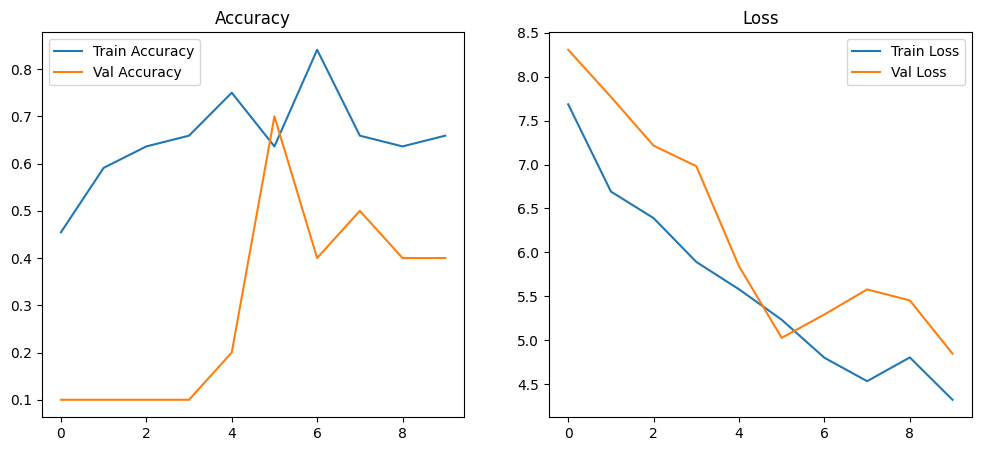

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Confusion Matrix:
[[0 1]
 [2 7]]


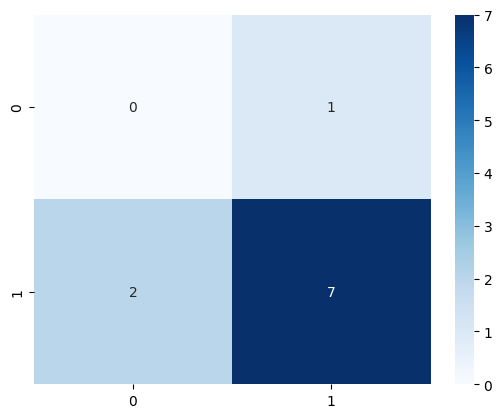


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      0.78      0.82         9

    accuracy                           0.70        10
   macro avg       0.44      0.39      0.41        10
weighted avg       0.79      0.70      0.74        10



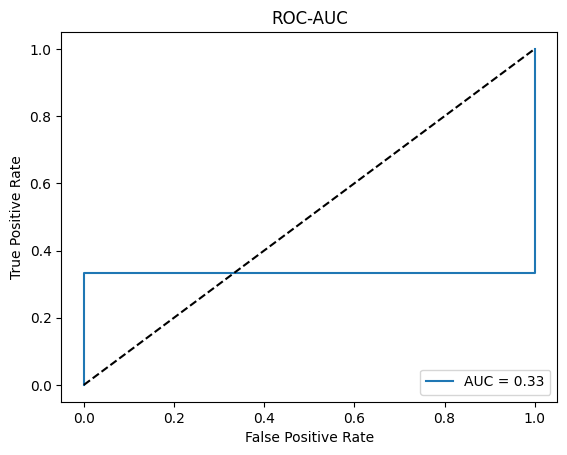

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

y_pred = model.predict([X_val_vid, X_val_aud])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
auc = roc_auc_score(y_true, y_pred[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC")
plt.legend(loc="lower right")
plt.show()


In [ ]:
print("Before cropping:")
print("Video test:", X_test_vid.shape)
print("Audio test:", X_test_aud.shape)
print("Y test:", y_test.shape)

min_test_len = min(len(X_test_vid), len(X_test_aud), len(y_test))
X_test_vid = X_test_vid[:min_test_len]
X_test_aud = X_test_aud[:min_test_len]
y_test = y_test[:min_test_len]

print("\nAfter cropping:")
print("Video test:", X_test_vid.shape)
print("Audio test:", X_test_aud.shape)
print("Y test:", y_test.shape)

score = model.evaluate([X_test_vid, X_test_aud], y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Before cropping:
Video test: (10, 10, 128, 128, 3)
Audio test: (10, 128, 128, 1)
Y test: (10, 2)

After cropping:
Video test: (10, 10, 128, 128, 3)
Audio test: (10, 128, 128, 1)
Y test: (10, 2)
Test Score: 4.84084415435791
Test Accuracy: 0.800000011920929


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/cd/model_fakereal.h5')
print("✅ Mô hình đã được lưu thành công.")

✅ Mô hình đã được lưu thành công.


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from google.colab import files

def preprocess_video(video_path, target_frames=10, img_size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, target_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, img_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame / 255.0)
    cap.release()

    if len(frames) < target_frames:
        frames += [np.zeros((img_size[0], img_size[1], 3))] * (target_frames - len(frames))

    return np.array(frames).reshape(1, target_frames, img_size[0], img_size[1], 3)

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cd/model_fakereal.h5")

uploaded = files.upload()
video_path = list(uploaded.keys())[0]

video_input = preprocess_video(video_path)
dummy_audio = np.zeros((1, 128, 128, 1))

pred = model.predict([video_input, dummy_audio])
label = "FAKE" if pred[0][0] >= 0.5 else "REAL"
confidence = pred[0][0] * 100 if label == "FAKE" else (1 - pred[0][0]) * 100

print(f"{label} ")


Saving biden-to-Trump.wav to biden-to-Trump.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
FAKE 


In [ ]:
!pip install streamlit pyngrok tensorflow librosa soundfile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 308wFZ9cGK2fsa4SsuQhFlWY67A_65j1sDc5murCNqGGeW4Kd

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import librosa
import soundfile as sf
import os

# Load model
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/cd/model_fakereal.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Hàm trích xuất MFCC
def extract_mfcc(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled

# App UI
st.title("🔊 Phân biệt Giọng nói Thật / Giả")
uploaded_file = st.file_uploader("Tải file âm thanh (.wav)", type=["wav"])

if uploaded_file is not None:
    # Lưu file tạm
    temp_path = "temp_audio.wav"
    with open(temp_path, "wb") as f:
        f.write(uploaded_file.read())

    # Xử lý đặc trưng
    features = extract_mfcc(temp_path)
    features = np.expand_dims(features, axis=0)  # shape (1, n_mfcc)

    # Dự đoán
    pred = model.predict(features)
    label = "🎯 Thật" if np.argmax(pred) == 1 else "⚠️ Giả"

    st.audio(uploaded_file, format="audio/wav")
    st.subheader(f"Kết quả: {label}")


Writing app.py


In [ ]:
from flask import Flask, request, render_template_string, url_for
from pyngrok import ngrok
import tensorflow as tf
import numpy as np
import librosa
import traceback
import matplotlib.pyplot as plt
import os
import uuid

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cd/model_fakereal.h5")

# Tạo thư mục static để lưu ảnh waveform
os.makedirs("static", exist_ok=True)

# Hàm tiền xử lý audio
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    desired_length = sr * 4
    if len(y) > desired_length:
        y = y[:desired_length]
    else:
        y = np.pad(y, (0, desired_length - len(y)), "constant")

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    if mel_spec_db.shape[1] > 128:
        mel_spec_db = mel_spec_db[:, :128]
    elif mel_spec_db.shape[1] < 128:
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, 128 - mel_spec_db.shape[1])), mode='constant')

    mel_spec_db = mel_spec_db[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)
    return mel_spec_db, y, sr

# Hàm vẽ waveform
def save_waveform(y, sr):
    plt.figure(figsize=(8, 3))
    plt.plot(np.linspace(0, len(y) / sr, num=len(y)), y, color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    filename = f"waveform_{uuid.uuid4().hex}.png"
    filepath = os.path.join("static", filename)
    plt.savefig(filepath)
    plt.close()
    return filename

app = Flask(__name__)

@app.route("/", methods=["GET"])
def index():
    return render_template_string('''
    <html>
        <head>
            <title>Dự đoán giọng nói</title>
            <style>
                body {
                    font-family: Arial, sans-serif;
                    text-align: center;
                    padding: 50px;
                    background-color: #f8f9fa;
                }
                h2 { color: #333; }
                .upload-box {
                    background: white;
                    padding: 20px;
                    border-radius: 10px;
                    display: inline-block;
                    box-shadow: 0 0 10px rgba(0,0,0,0.1);
                }
                input[type=file] { margin: 10px 0; }
                input[type=submit] {
                    background: #28a745;
                    color: white;
                    border: none;
                    padding: 10px 20px;
                    border-radius: 5px;
                    cursor: pointer;
                }
                input[type=submit]:hover { background: #218838; }
            </style>
        </head>
        <body>
            <div class="upload-box">
                <h2>Upload file audio (.wav)</h2>
                <form action="/predict" method="post" enctype="multipart/form-data">
                    <input type="file" name="audio" accept=".wav" required><br>
                    <input type="submit" value="Dự đoán">
                </form>
            </div>
        </body>
    </html>
    ''')

@app.route("/predict", methods=["POST"])
def predict():
    try:
        if "audio" not in request.files:
            return "Không có file audio"

        file = request.files["audio"]

        # Lưu file vào static để có thể phát lại
        audio_filename = f"audio_{uuid.uuid4().hex}.wav"
        audio_path = os.path.join("static", audio_filename)
        file.save(audio_path)

        # Dummy video input
        video_dummy = np.zeros((1, 10, 128, 128, 3), dtype=np.float32)

        # Xử lý audio + lấy sóng để vẽ
        audio_features, y, sr = preprocess_audio(audio_path)

        # Vẽ waveform và lưu file ảnh
        waveform_img = save_waveform(y, sr)

        # Dự đoán
        pred = model.predict([video_dummy, audio_features])
        label = "Giọng thật" if pred[0][0] >= 0.6 else "Giọng giả"

        return render_template_string(f'''
        <html>
            <head>
                <title>Kết quả</title>
                <style>
                    body {{
                        font-family: Arial, sans-serif;
                        text-align: center;
                        padding: 50px;
                        background-color: #f8f9fa;
                    }}
                    .result-box {{
                        background: white;
                        padding: 20px;
                        border-radius: 10px;
                        display: inline-block;
                        box-shadow: 0 0 10px rgba(0,0,0,0.1);
                    }}
                    a {{
                        display: inline-block;
                        margin-top: 15px;
                        background: #007bff;
                        color: white;
                        padding: 10px 20px;
                        text-decoration: none;
                        border-radius: 5px;
                    }}
                    a:hover {{ background: #0056b3; }}
                </style>
            </head>
            <body>
                <div class="result-box">
                    <h2>Kết quả: {label}</h2>
                    <audio controls>
                        <source src="{url_for('static', filename=audio_filename)}" type="audio/wav">
                        Trình duyệt của bạn không hỗ trợ phát audio.
                    </audio><br><br>
                    <img src="{url_for('static', filename=waveform_img)}" alt="Waveform"><br><br>
                    <a href="/">⬅ Quay lại</a>
                </div>
            </body>
        </html>
        ''')

    except Exception as e:
        print("==== LỖI TRONG /predict ====")
        traceback.print_exc()
        return f"Lỗi: {str(e)}"


if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print("Ngrok URL:", public_url)
    app.run(port=5000)


Ngrok URL: NgrokTunnel: "https://4f142a22f1a4.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:00:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:00:25] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:22] "GET /static/waveform_dd3299ef354748b6b046f66dabc9f6ec.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:42] "GET /static/audio_48f3bb1822a541ea9230aee372fa9a70.wav HTTP/1.1" 206 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:42] "GET /static/audio_48f3bb1822a541ea9230aee372fa9a70.wav HTTP/1.1" 206 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:43] "GET /static/audio_48f3bb1822a541ea9230aee372fa9a70.wav HTTP/1.1" 206 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:01:44] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Aug/2025 01:02:11] "GET / HTTP/1.1" 200 -


In [ ]:
from pyngrok import ngrok
ngrok.kill()
